<a href="https://colab.research.google.com/github/ValdazoAmerico/sentiment-analysis-SGD/blob/main/sentiment_analysis_SGD_Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
import os
import io
import re
from sys import path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from string import punctuation, digits
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [3]:
input_file = "amazon_cells_labeled.txt"
amazon = pd.read_csv(input_file, delimiter="\t", header=None)
amazon.columns = ['Sentence', 'Class']

In [6]:
input_file = "imdb_labelled.txt"
imdb = pd.read_csv(input_file, delimiter="\t", header=None)
imdb.columns = ['Sentence', 'Class']

In [7]:
input_file = "yelp_labelled.txt"
yelp = pd.read_csv(input_file, delimiter="\t", header=None)
yelp.columns = ['Sentence', 'Class']

In [8]:
data = pd.DataFrame()
data = pd.concat([amazon, yelp, imdb])
data['index'] = data.index
print(data)

                                              Sentence  Class  index
0    So there is no way for me to plug it in here i...      0      0
1                          Good case, Excellent value.      1      1
2                               Great for the jawbone.      1      2
3    Tied to charger for conversations lasting more...      0      3
4                                    The mic is great.      1      4
..                                                 ...    ...    ...
743  I just got bored watching Jessice Lange take h...      0    743
744  Unfortunately, any virtue in this film's produ...      0    744
745                   In a word, it is embarrassing.        0    745
746                               Exceptionally bad!        0    746
747  All in all its an insult to one's intelligence...      0    747

[2748 rows x 3 columns]


In [18]:
columns = ['index', 'Class', 'Sentence']
df_ = pd.DataFrame(columns=columns)
data['Sentence'] = data['Sentence'].str.lower()
data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
data['Sentence'] = data['Sentence'].replace('[^\w\s]', '')
data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)

In [19]:
for index, row in data.iterrows():
  word_tokens = word_tokenize(row['Sentence'])
  filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
  df_ = df_.append({'index': row['index'], "Class": row['Class'], "Sentence": " ".join(filtered_sentence[0:])}, ignore_index=True)
data = df_
print("data", data)

data      index Class                                           Sentence
0        0     0                  way plug us unless go converter .
1        1     1                      good case , excellent value .
2        2     1                                    great jawbone .
3        3     0  tied charger conversations lasting minutes.maj...
4        4     1                                        mic great .
...    ...   ...                                                ...
2743   743     0    got bored watching jessice lange take clothes !
2744   744     0  unfortunately , virtue film 's production work...
2745   745     0                              word , embarrassing .
2746   746     0                                exceptionally bad !
2747   747     0      insult one 's intelligence huge waste money .

[2748 rows x 3 columns]


In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
import nltk

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data['Sentence'].values.astype('U'),data['Class'].values.astype('int32'), test_size=0.10, random_state=0)
classes = data['Class'].unique()

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5,use_idf=True,norm='l2')
counts = vectorizer.fit_transform(X_train)
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(alpha=1e-05, max_iter=50,penalty='elasticnet')
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
predictions = classifier.predict(example_counts)



from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

acc = accuracy_score(y_test, predictions, normalize=True)
hit = precision_score(y_test, predictions, average=None,labels=classes)
capture=recall_score(y_test,predictions,average=None,labels=classes)
print('Model accuracy:%.2f'%acc)
print(classification_report(y_test, predictions))

Model accuracy:0.80
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       139
           1       0.84      0.74      0.79       136

    accuracy                           0.80       275
   macro avg       0.81      0.80      0.80       275
weighted avg       0.81      0.80      0.80       275



In [38]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

        if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
          print()
        plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks,classes,rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
          horizontalalignment = "center",
          color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.figure(figsize=(150,100))



   Category  Index
0         0      1
1         1      2


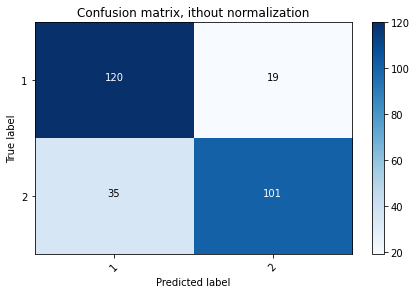

<Figure size 10800x7200 with 0 Axes>

In [39]:
cnf_matrix = confusion_matrix(y_test, predictions, classes)
np.set_printoptions(precision=2)
class_names = range(1,classes.size+1)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title="Confusion matrix, ithout normalization")
classInfo = pd.DataFrame(data=[])

for i in range(0,classes.size):
  classInfo = classInfo.append([[classes[i], i+1]],ignore_index=True)
classInfo.columns=['Category','Index']
print(classInfo)